# Loading Previously trained models and applying CAM

In [1]:
import zipfile, torch, random 
from torchvision import models, transforms
import torch.nn.functional as F
from os import walk
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import skimage.transform
import matplotlib.patches as mpatches

### Several Variables

In [2]:
# Imagenet mean/std
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Scale to 224x224, convert to tensor, and normalize with mean/std for ImageNet
preprocess = transforms.Compose([
   transforms.Resize((224, 224)),
   transforms.ToTensor(),
   normalize,
])

# Using CAM on your model

# Get the features from a model
class SaveFeatures():
    features = None
    def __init__(self, module): 
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output): 
        self.features = output.data.numpy()

    def remove(self): 
        self.hook.remove()

def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h * w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

# Model Trained on STL-10, without Background Images

In [3]:
Num_class=10
folderlocation = './data/'

with zipfile.ZipFile('/kaggle/input/stl-10-wideresnet-save-model-for-cam/STL_data.zip.zip', 'r') as zip_ref:
    zip_ref.extractall(folderlocation)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.wide_resnet101_2(pretrained=False) #We only need the structure to transfer parameters
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, Num_class)

model.load_state_dict(torch.load('/kaggle/input/stl-10-wideresnet-save-model-for-cam/best_model.pt', map_location=device))

<All keys matched successfully>

In [5]:
print(num_ftrs)

2048


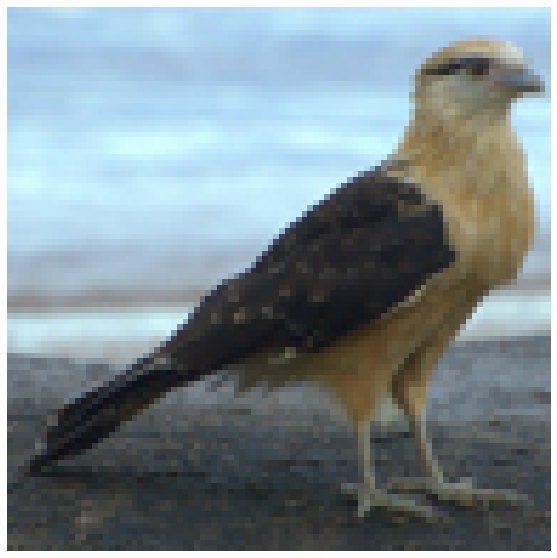

In [6]:
Classnames = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
PATH = '/kaggle/working/data/STL10/test/1/'
filenames = next(walk(PATH), (None, None, []))[2]  # [] if no file

# Show the image
image = Image.open(PATH + sorted(filenames)[2]) 
plt.figure(figsize=(15, 10))
plt.imshow(image)
plt.axis('off')
plt.savefig('Sample_image.pdf', bbox_inches = 'tight') 
plt.show()

In [7]:
# Get features from last conv layer
final_layer = model._modules.get('layer4')
activated_features = SaveFeatures(final_layer)

x_img = preprocess(image).unsqueeze(0)
# Inference
x_img = x_img.to(device)
_ = model.eval()
prediction = model(x_img)


pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()
print('Top-1 prediction:', torch.topk(pred_probabilities, 1))

# Take weights from the first linear layer
weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].data.numpy())

# Get the top-1 prediction and get CAM
class_idx = torch.topk(pred_probabilities, Num_class)[1].int()
print("Class ID:", class_idx)

Top-1 prediction: torch.return_types.topk(
values=tensor([0.9998]),
indices=tensor([1]))
Class ID: tensor([1, 0, 5, 4, 7, 3, 8, 6, 2, 9], dtype=torch.int32)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == "":


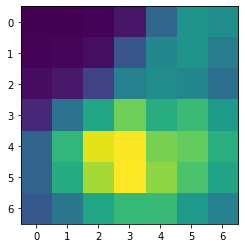

In [8]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx[2])
Extended_cam2 = skimage.transform.resize(overlay[0], (image.size[1], image.size[0]))

overlay = getCAM(activated_features.features, weight_softmax, class_idx[1])
Extended_cam1 = skimage.transform.resize(overlay[0], (image.size[1], image.size[0]))

overlay = getCAM(activated_features.features, weight_softmax, class_idx[0])
Extended_cam = skimage.transform.resize(overlay[0], (image.size[1], image.size[0]))

plt.imshow(overlay[0])
plt.show()

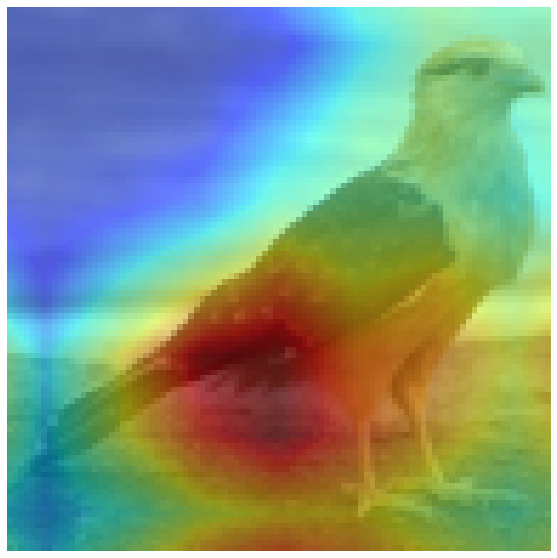

In [9]:
# Show CAM on the image
plt.figure(figsize=(15, 10))
#plt.title('Class Activation Map on the Image', fontweight='bold')
plt.imshow(image)
plt.imshow(skimage.transform.resize(Extended_cam, (image.size[1], image.size[0])), alpha=0.5, cmap='jet');
plt.axis('off')
plt.savefig('Deep_CAM.pdf', bbox_inches = 'tight') 
plt.show()

# Deep Features by Major Activation STL-10, without Background

In [10]:
#Merge cam
CAM_Merge = np.zeros((image.size[1], image.size[0],3))
for iter1 in range(image.size[1]):
    for iter2 in range(image.size[0]):
        class_id_pixel = np.argmax([Extended_cam[iter1,iter2],Extended_cam1[iter1,iter2],Extended_cam2[iter1,iter2]])
        if class_id_pixel ==0:                        
            CAM_Merge[iter1,iter2,1] = 255*Extended_cam[iter1,iter2] # First detected class is green
        if class_id_pixel ==1:                        
            CAM_Merge[iter1,iter2,0] = 255*Extended_cam1[iter1,iter2] # Second detected class is red
        if class_id_pixel ==2:                        
            CAM_Merge[iter1,iter2,2] = 255*Extended_cam2[iter1,iter2] # Third detected class is blue



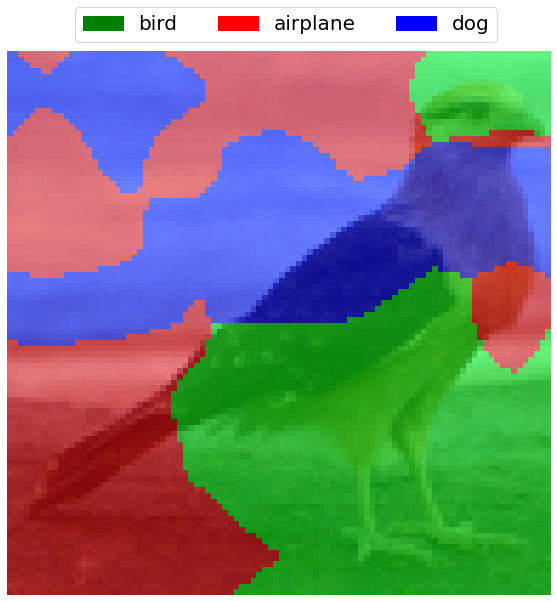

In [11]:
plt.figure(figsize=(15, 10))
#plt.title('Class Activation Map on the Image', fontweight='bold')
plt.imshow(image)
plt.imshow(skimage.transform.resize(CAM_Merge, (image.size[1], image.size[0])), alpha=0.5, cmap='jet');
plt.axis('off')

red_patch = mpatches.Patch(color='red', label=Classnames[class_idx[1]])
green_patch = mpatches.Patch(color='green', label=Classnames[class_idx[0]])
blue_patch = mpatches.Patch(color='blue', label=Classnames[class_idx[2]])
plt.legend(handles=[green_patch, red_patch, blue_patch],bbox_to_anchor =(0.92, 1.1),ncol=3,fontsize=20)
plt.savefig('Deep_feature.pdf', bbox_inches = 'tight')
plt.show()

# Model Trained on STL-10, with Background Images

In [12]:
Classnames_background = ['airplane', 'bird', 'background', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 
                         'ship', 'truck']

model2 = models.wide_resnet101_2(pretrained=False) #We only need the structure to transfer parameters
num_ftrs = model.fc.in_features
model2.fc = torch.nn.Linear(num_ftrs, Num_class+1)

model2.load_state_dict(torch.load('/kaggle/input/stl-10-with-background/model_background.pt', map_location=device))

<All keys matched successfully>

In [13]:
# Get features from last conv layer
final_layer = model2._modules.get('layer4')
activated_features = SaveFeatures(final_layer)

x_img = preprocess(image).unsqueeze(0)
# Inference
x_img = x_img.to(device)
_ = model2.eval()
prediction = model2(x_img)


pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()
print('Top-1 prediction:', torch.topk(pred_probabilities, 1))

# Take weights from the first linear layer
weight_softmax_params = list(model2._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].data.numpy())

# Get the top-1 prediction and get CAM
class_idx = torch.topk(pred_probabilities, Num_class+1)[1].int()
print("Class ID:", class_idx)

Top-1 prediction: torch.return_types.topk(
values=tensor([1.0000]),
indices=tensor([1]))
Class ID: tensor([ 1,  5,  6,  0,  9,  8,  4,  7,  3, 10,  2], dtype=torch.int32)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == "":


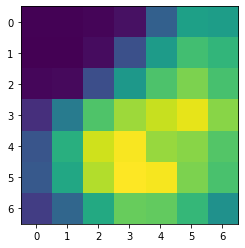

In [14]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx[2])
Extended_cam2 = skimage.transform.resize(overlay[0], (image.size[1], image.size[0]))

overlay = getCAM(activated_features.features, weight_softmax, class_idx[1])
Extended_cam1 = skimage.transform.resize(overlay[0], (image.size[1], image.size[0]))

overlay = getCAM(activated_features.features, weight_softmax, class_idx[0])
Extended_cam = skimage.transform.resize(overlay[0], (image.size[1], image.size[0]))

plt.imshow(overlay[0])
plt.show()

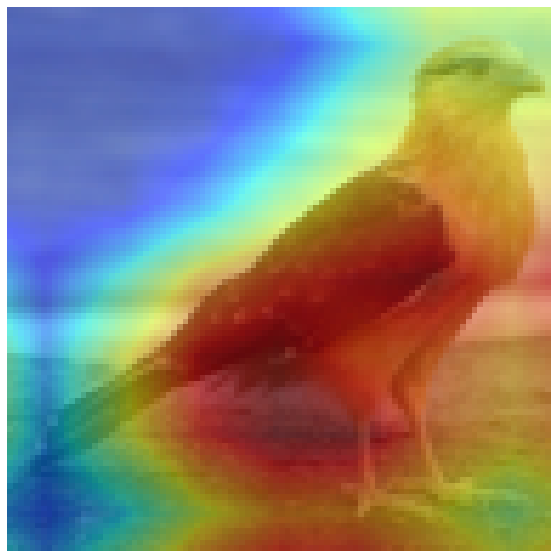

In [15]:
# Show CAM on the image
plt.figure(figsize=(15, 10))
#plt.title('Class Activation Map on the Image', fontweight='bold')
plt.imshow(image)
plt.imshow(skimage.transform.resize(Extended_cam, (image.size[1], image.size[0])), alpha=0.5, cmap='jet');
plt.axis('off')
plt.savefig('Deep_CAM_background.pdf', bbox_inches = 'tight') 
plt.show()

# Deep Features by Major Activation STL-10, with Background

In [16]:
#Merge cam
CAM_Merge = np.zeros((image.size[1], image.size[0],3))
for iter1 in range(image.size[1]):
    for iter2 in range(image.size[0]):
        class_id_pixel = np.argmax([Extended_cam[iter1,iter2],Extended_cam1[iter1,iter2],Extended_cam2[iter1,iter2]])
        if class_id_pixel ==0:                        
            CAM_Merge[iter1,iter2,1] = 255*Extended_cam[iter1,iter2] # First detected class is green
        if class_id_pixel ==1:                        
            CAM_Merge[iter1,iter2,0] = 255*Extended_cam1[iter1,iter2] # Second detected class is red
        if class_id_pixel ==2:                        
            CAM_Merge[iter1,iter2,2] = 255*Extended_cam2[iter1,iter2] # Third detected class is blue

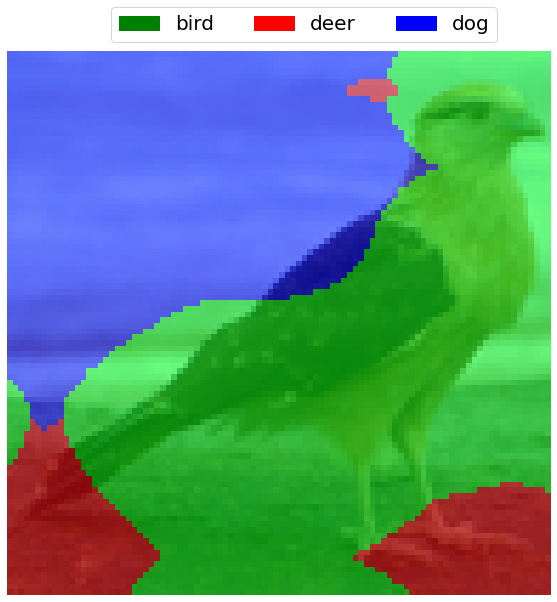

In [17]:
plt.figure(figsize=(15, 10))
#plt.title('Class Activation Map on the Image', fontweight='bold')
plt.imshow(image)
plt.imshow(skimage.transform.resize(CAM_Merge, (image.size[1], image.size[0])), alpha=0.5, cmap='jet');
plt.axis('off')

red_patch = mpatches.Patch(color='red', label=Classnames_background[class_idx[1]])
green_patch = mpatches.Patch(color='green', label=Classnames_background[class_idx[0]])
blue_patch = mpatches.Patch(color='blue', label=Classnames_background[class_idx[2]])
plt.legend(handles=[green_patch, red_patch, blue_patch],bbox_to_anchor =(0.92, 1.1),ncol=3,fontsize=20)
plt.savefig('Deep_feature_background.pdf', bbox_inches = 'tight') 
plt.show()

## Delete Extracted Data

In [18]:
import shutil
shutil.rmtree('./data/')